In [15]:
import os
import sys

import torch
from torchani.models import ANI2x

repo_root = os.path.abspath(os.path.join("/home/armin/Documents/GADES/examples/ANI_Validation/", '..', '..'))
sys.path.insert(0, os.path.join(repo_root, 'GADES'))

from utils import compute_hessian_force_fd_block_serial as get_gades_hess
from utils import compute_hessian_force_fd_richardson as get_gades_hess_re

import numpy as np
import openmm.app as app
from openmm import unit
from openmm.openmm import LangevinIntegrator

from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
model = ANI2x(periodic_table_index=True).to(device)
model = model.to(dtype=torch.float64)

/home/armin/miniconda3/envs/GADES/lib/python3.11/site-packages/torchani/resources/


In [4]:
prmtop = app.AmberPrmtopFile(f"alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"alanine-dipeptide.inpcrd")
coordinates = torch.tensor(inpcrd.getPositions(asNumpy=True).value_in_unit(unit.angstrom),
                           requires_grad=True, device=device, dtype=torch.float32).view(1, -1, 3)
coordinates = coordinates.to(dtype=torch.float64)
# In periodic table, C = 6 and H = 1
species = torch.tensor([i.element.atomic_number for i in prmtop.topology.atoms()], device=device).view(1, -1)

In [5]:
energy = model((species, coordinates)).energies
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
hessian = torch.autograd.functional.hessian(lambda x: model((species, x.reshape(1, 22, 3))).energies*2625.50*100, coordinates.reshape(-1).detach().requires_grad_(True))
force = -derivative

In [6]:
from openmmml import MLPotential

potential = MLPotential('ani2x')
system = potential.createSystem(prmtop.topology)

integrator = LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)

simulation = app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

/home/armin/miniconda3/envs/GADES/lib/python3.11/site-packages/torchani/resources/


In [7]:
hess = torch.tensor(get_gades_hess(simulation.system, inpcrd.positions, None, 1e-5, "CPU"))
hess_re = torch.tensor(get_gades_hess_re(simulation.system, inpcrd.positions, None, 1e-4, "CPU"))

In [8]:
ani_hess = hessian.view(66, 66).cpu().numpy()   # 22 atoms × 3 coords = 66
gades_hess = hess.numpy()
rich_hess = hess_re.numpy()

error_norm = np.linalg.norm(gades_hess - ani_hess)
rel_error = error_norm / np.linalg.norm(ani_hess)

print(f"Absolute error: {error_norm:.3e}")
print(f"Relative error: {rel_error:.3e}")

error_norm = np.linalg.norm(rich_hess - ani_hess)
rel_error = error_norm / np.linalg.norm(ani_hess)

print(f"Richardson3 Absolute error: {error_norm:.3e}")
print(f"Richardson3 Relative error: {rel_error:.3e}")

Absolute error: 9.414e+03
Relative error: 2.244e-03
Richardson3 Absolute error: 9.165e+03
Richardson3 Relative error: 2.185e-03


In [9]:
p_errors = torch.abs(torch.triu(hess)-(torch.triu(hessian)+1e-6))/torch.abs(torch.triu(hessian)+1e-6) *100

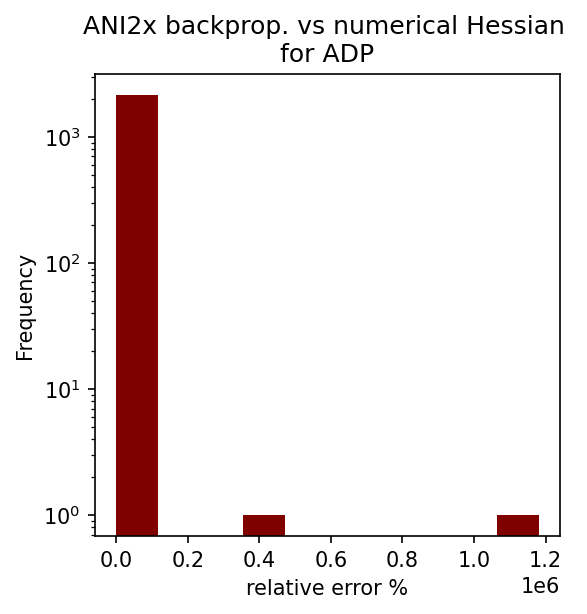

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 4))
ax.hist(p_errors.flatten()[:66*65//2], bins=10, color='#800000')
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("relative error %")
ax.set_title("ANI2x backprop. vs numerical Hessian \nfor ADP")
plt.show()

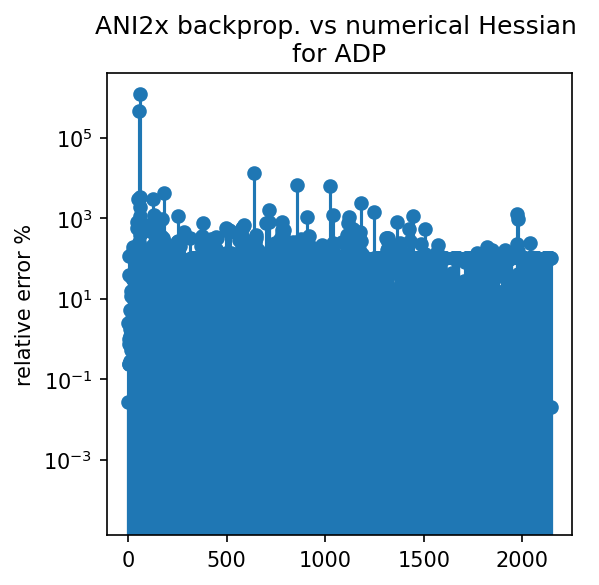

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 4))
ax.stem(np.arange(0, 66*65//2), p_errors.flatten()[:66*65//2])
ax.set_yscale("log")
ax.set_ylabel("index")
ax.set_ylabel("relative error %")
ax.set_title("ANI2x backprop. vs numerical Hessian \nfor ADP")
plt.show()

In [ ]:
def get_relative_error(approx_hess, ref_hess):
    diff = approx_hess - ref_hess
    return np.linalg.norm(diff) / np.linalg.norm(ref_hess)

# Convert autograd Hessian to numpy for comparison
ani_hessian = hessian.view(66, 66).detach().cpu().numpy()

epsilons = np.logspace(-6, -1, 15)
errors_fd, errors_r1, errors_r3,  errors_r5= [], [], [], []

for eps in tqdm(epsilons):
    h_fd = get_gades_hess(simulation.system, inpcrd.positions, None, eps, "CPU")
    h_r1 = get_gades_hess_re(system, inpcrd.positions, None, eps, "CPU", factors=[1, 0.5])
    h_r3 = get_gades_hess_re(system, inpcrd.positions, None, eps, "CPU", factors=[1, 0.5, 0.25, 0.125])
    h_r5 = get_gades_hess_re(system, inpcrd.positions, None, eps, "CPU", factors=[1, 0.5, 0.25, 0.125, 0.0625])

    errors_fd.append(np.linalg.norm(h_fd - ani_hessian) / np.linalg.norm(ani_hessian))
    errors_r1.append(np.linalg.norm(h_r1 - ani_hessian) / np.linalg.norm(ani_hessian))
    errors_r3.append(np.linalg.norm(h_r3 - ani_hessian) / np.linalg.norm(ani_hessian))
    errors_r5.append(np.linalg.norm(h_r5 - ani_hessian) / np.linalg.norm(ani_hessian))

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.loglog(epsilons, errors_fd, 'o-', label='Forward FD (O(ε))')
plt.loglog(epsilons, errors_r1, '^-', label='2-step Richardson (O(ε2))')
plt.loglog(epsilons, errors_r3, '^-', label='2-step Richardson (O(ε3))')
plt.loglog(epsilons, errors_r5, '^-', label='2-step Richardson (O(ε5))')

# Reference slopes
#ref_eps = np.array([1e-6, 1e-2])
#plt.loglog(ref_eps, 1e0 * ref_eps, 'k--', label='ε¹')
#plt.loglog(ref_eps, 1e-2 * ref_eps**3, 'k:', label='ε³')

plt.xlabel("ε (finite difference step size)")
plt.ylabel("Relative error vs. ANI Hessian")
plt.title("Hessian Accuracy vs. Step Size")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
def compare_spectrum_and_soft_mode(H_ref, H_test, label_ref="Reference", label_test="Test"):
    # Diagonalize both Hessians
    evals_ref, evecs_ref = np.linalg.eigh(H_ref)
    evals_test, evecs_test = np.linalg.eigh(H_test)

    # Sort eigenvalues (and vectors) ascending
    idx_ref = np.argsort(evals_ref)
    idx_test = np.argsort(evals_test)

    evals_ref = evals_ref[idx_ref]
    evals_test = evals_test[idx_test]
    evecs_ref = evecs_ref[:, idx_ref]
    evecs_test = evecs_test[:, idx_test]

    # Compare softest mode (lowest eigenvalue)
    v_ref = evecs_ref[:, 0]
    v_test = evecs_test[:, 0]

    # Normalize (should be already, but to be safe)
    v_ref /= np.linalg.norm(v_ref)
    v_test /= np.linalg.norm(v_test)

    # Cosine similarity = dot product
    cos_sim = np.abs(np.dot(v_ref, v_test))

    return {
        "softest_eval_ref": evals_ref[0],
        "softest_eval_test": evals_test[0],
        "cosine_similarity": cos_sim,
        "evals_ref": evals_ref,
        "evals_test": evals_test
    }

In [19]:
softest_evals_fd, cosine_sims_fd = [], []
softest_evals_e2, cosine_sims_e2 = [], []
softest_evals_e3, cosine_sims_e3 = [], []
epsilons = np.logspace(-6, -1, 15)

for eps in tqdm(epsilons):
    H_test = get_gades_hess(system, inpcrd.positions, None, eps, "CPU")
    res = compare_spectrum_and_soft_mode(ani_hessian, H_test)
    softest_evals_fd.append((res["softest_eval_test"] - res["softest_eval_ref"])/res["softest_eval_ref"])
    cosine_sims_fd.append(res["cosine_similarity"])
    H_test = get_gades_hess_re(system, inpcrd.positions, None, eps, "CPU", factors=[1, 0.5])
    res = compare_spectrum_and_soft_mode(ani_hessian, H_test)
    softest_evals_e2.append((res["softest_eval_test"] - res["softest_eval_ref"])/res["softest_eval_ref"])
    cosine_sims_e2.append(res["cosine_similarity"])
    H_test = get_gades_hess_re(system, inpcrd.positions, None, eps, "CPU", factors=[1, 0.5, 0.25])
    res = compare_spectrum_and_soft_mode(ani_hessian, H_test)
    softest_evals_e3.append((res["softest_eval_test"] - res["softest_eval_ref"])/res["softest_eval_ref"])
    cosine_sims_e3.append(res["cosine_similarity"])

  0%|          | 0/15 [00:00<?, ?it/s]

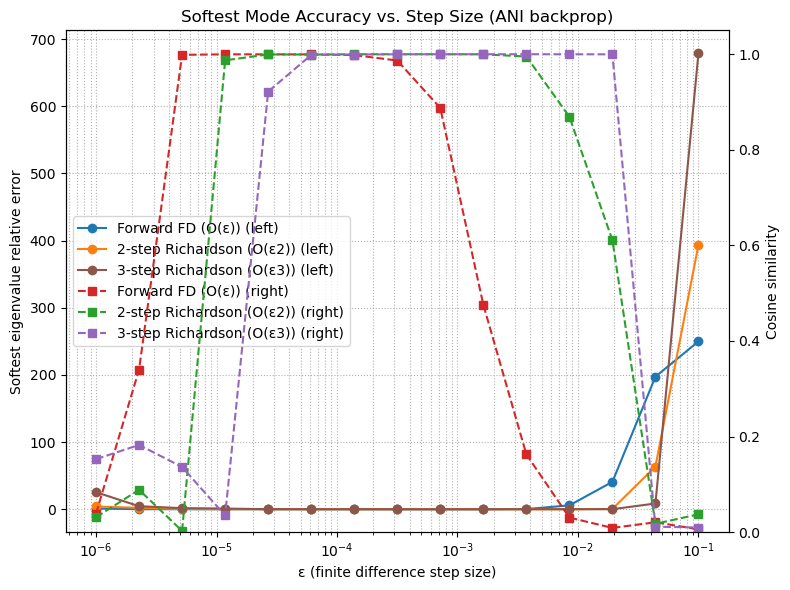

In [21]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: relative error
ax1.plot(epsilons, softest_evals_fd, 'o-', color='tab:blue', label='Forward FD (O(ε)) (left)')
ax1.plot(epsilons, softest_evals_e2, 'o-', color='tab:orange', label='2-step Richardson (O(ε2)) (left)')
ax1.plot(epsilons, softest_evals_e3, 'o-', color='tab:brown', label='3-step Richardson (O(ε3)) (left)')
ax1.set_xlabel("ε (finite difference step size)")
ax1.set_ylabel("Softest eigenvalue relative error")
ax1.tick_params(axis='y')
ax1.set_xscale("log")
ax1.grid(True, which="both", ls=":")

# Right y-axis: cosine similarity
ax2 = ax1.twinx()
ax2.plot(epsilons, cosine_sims_fd, 's--', color='tab:red', label='Forward FD (O(ε)) (right)')
ax2.plot(epsilons, cosine_sims_e2, 's--', color='tab:green', label='2-step Richardson (O(ε2)) (right)')
ax2.plot(epsilons, cosine_sims_e3, 's--', color='tab:purple', label='3-step Richardson (O(ε3)) (right)')
ax2.set_ylabel("Cosine similarity")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1.05)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left')

plt.title("Softest Mode Accuracy vs. Step Size (ANI backprop)")
plt.tight_layout()
plt.show()